In [1]:
import numpy as np 
import pandas as pd 
import math 
from datetime import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_treatment = pd.read_csv("/Users/yzm9199/Downloads/Patient_Treatment.csv", encoding = 'utf8', sep=",")
df_diagnosis = pd.read_csv("/Users/yzm9199/Downloads/Patient_Diagnosis.csv", encoding = 'utf8', sep=",")

### Pre-processing: Remove duplicate rows

In [3]:
df_treatment = df_treatment.drop_duplicates() 
df_diagnosis = df_diagnosis.drop_duplicates() 

### Examine: Concurrent diagnosis

In [4]:
# remove duplicate diagnosis
df_diagnosis_pt = df_diagnosis[['patient_id', 'diagnosis_date', 'diagnosis']].sort_values(['patient_id', 'diagnosis_date']).drop_duplicates() 

# count patients' concurrent treatments in total
dx_count = df_diagnosis_pt.groupby(['patient_id']).size().reset_index(name='count')

# identify patients with two diagnosis
dx_count = dx_count[dx_count['count']==2]
dx_count

,patient_id,count
21,3757,2
34,6877,2
35,6889,2
36,6922,2
37,7230,2


In [5]:
# map total counts of diagnosis to the diagnosis table
mydict = {}
for row in dx_count.itertuples():
    k = row.patient_id
    v = row.count
    mydict[k]=v
df_diagnosis_pt['count'] = df_diagnosis_pt['patient_id'].map(mydict)
df_diagnosis_pt[df_diagnosis_pt['count']==2]

,patient_id,diagnosis_date,diagnosis,count
20,3757,10/11/11,Breast Cancer,2.0
21,3757,10/17/11,Colon Cancer,2.0
44,6877,11/26/12,Colon Cancer,2.0
45,6877,12/9/12,Breast Cancer,2.0
39,6889,11/14/12,Colon Cancer,2.0
42,6889,11/17/12,Breast Cancer,2.0
41,6922,11/15/12,Colon Cancer,2.0
43,6922,11/20/12,Breast Cancer,2.0
46,7230,1/2/13,Colon Cancer,2.0
48,7230,1/6/13,Breast Cancer,2.0


### Examine: Concurrent treatments

In [8]:
# get initial diagnosis date
df_diagnosis_date = df_diagnosis[['patient_id', 'diagnosis_date', 'diagnosis']].sort_values(['patient_id', 'diagnosis_date']).drop_duplicates(subset=['patient_id'])

# map first diagnosis date to the treatment table
mydict = {}
for row in df_diagnosis_date.itertuples():
    k = row.patient_id
    v = row.diagnosis_date
    mydict[k]=v
df_treatment['diagnosis_date'] = df_treatment['patient_id'].map(mydict)

In [9]:
# count patients' concurrent treatments in total
tr_count = df_treatment.groupby(['patient_id', 'treatment_date']).size().reset_index(name='count')

# identify patients with two or more concurrent treatments
tr_count = tr_count[tr_count['count']>=2]
tr_count

,patient_id,treatment_date,count
0,2038,1/24/10,2
2,2038,1/27/10,2
4,2038,1/30/10,2
18,2120,1/26/10,2
19,2120,1/27/10,2
...,...,...,...
787,9331,8/29/13,2
788,9331,9/10/13,2
789,9331,9/16/13,2
790,9331,9/22/13,2


In [10]:
# format dates to datetime
df_treatment['diagnosis_date']= pd.to_datetime(df_treatment['diagnosis_date'])
df_treatment['treatment_date']= pd.to_datetime(df_treatment['treatment_date'])

# create an id for unique patient_id + treatment_date combination for initial diagnosis
df_treatment['id'] = df_treatment['patient_id'].astype(str)+"_"+df_treatment['treatment_date'].astype(str)

# format dates to datetime and create an id for unique patient_id + treatment_date combination for tr_count
tr_count['treatment_date']= pd.to_datetime(tr_count['treatment_date'])
tr_count['id'] = tr_count['patient_id'].astype(str)+"_"+tr_count['treatment_date'].astype(str)

# map total counts of diagnosis to the diagnosis table
mydict = {}
for row in tr_count.itertuples():
    k = row.id
    v = row.count
    mydict[k]=v
df_treatment['count'] = df_treatment['id'].map(mydict)
df_treatment[df_treatment['count']!=2]

,patient_id,treatment_date,drug_code,diagnosis_date,id,count
0,2720,2010-01-20,B,2010-01-09,2720_2010-01-20,NaN
1,2238,2010-01-21,B,2010-01-21,2238_2010-01-21,NaN
2,2120,2010-01-23,B,2010-01-09,2120_2010-01-23,NaN
4,2120,2010-01-24,A,2010-01-09,2120_2010-01-24,NaN
12,2720,2010-01-27,B,2010-01-09,2720_2010-01-27,NaN
...,...,...,...,...,...,...
1091,2038,2017-02-02,A,2010-01-21,2038_2017-02-02,NaN
1092,2038,2017-02-06,A,2010-01-21,2038_2017-02-06,NaN
1093,2038,2017-02-11,A,2010-01-21,2038_2017-02-11,NaN
1094,2038,2017-02-18,A,2010-01-21,2038_2017-02-18,NaN


### Examine: Duration of therapy

In [11]:
# identify treatment starts before diagnosis
df_treatment['date_diff'] = (df_treatment['treatment_date']-df_treatment['diagnosis_date']).dt.days
df_treatment = df_treatment.sort_values(['patient_id', 'treatment_date', 'drug_code'])

# first treatment from initial diagnosis date
df_treatment['time_min'] = df_treatment.groupby(['patient_id'])['date_diff'].transform(min)

# last treatment from initial diagnosis date
df_treatment['time_max'] = df_treatment.groupby(['patient_id'])['date_diff'].transform(max)

# treatment duration
df_treatment['duration'] = df_treatment['time_max'] - df_treatment['time_min']
df_treatment

,patient_id,treatment_date,drug_code,diagnosis_date,id,count,date_diff,time_min,time_max,duration
3,2038,2010-01-24,A,2010-01-21,2038_2010-01-24,2.0,3,3,2587,2584
5,2038,2010-01-24,B,2010-01-21,2038_2010-01-24,2.0,3,3,2587,2584
8,2038,2010-01-27,A,2010-01-21,2038_2010-01-27,2.0,6,3,2587,2584
9,2038,2010-01-27,B,2010-01-21,2038_2010-01-27,2.0,6,3,2587,2584
15,2038,2010-01-30,A,2010-01-21,2038_2010-01-30,2.0,9,3,2587,2584
...,...,...,...,...,...,...,...,...,...,...
1024,9489,2013-09-18,C,2013-08-19,9489_2013-09-18,NaN,30,6,53,47
1031,9489,2013-09-24,C,2013-08-19,9489_2013-09-24,NaN,36,6,53,47
1035,9489,2013-09-30,C,2013-08-19,9489_2013-09-30,NaN,42,6,53,47
1039,9489,2013-10-06,C,2013-08-19,9489_2013-10-06,NaN,48,6,53,47


array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

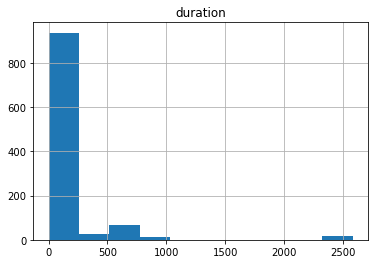

In [12]:
df_treatment.hist(column='duration')

In [13]:
df_treatment[df_treatment['duration'] < 2000][df_treatment['duration'] > 1000]

<ipython-input-13-73f5107f8ba6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treatment[df_treatment['duration'] < 2000][df_treatment['duration'] > 1000]


,patient_id,treatment_date,drug_code,diagnosis_date,id,count,date_diff,time_min,time_max,duration
1,2238,2010-01-21,B,2010-01-21,2238_2010-01-21,NaN,0,0,1001,1001
17,2238,2010-01-31,B,2010-01-21,2238_2010-01-31,NaN,10,0,1001,1001
29,2238,2010-02-10,B,2010-01-21,2238_2010-02-10,NaN,20,0,1001,1001
50,2238,2010-02-20,B,2010-01-21,2238_2010-02-20,NaN,30,0,1001,1001
64,2238,2010-03-02,B,2010-01-21,2238_2010-03-02,NaN,40,0,1001,1001
70,2238,2010-03-12,B,2010-01-21,2238_2010-03-12,NaN,50,0,1001,1001
78,2238,2010-03-22,B,2010-01-21,2238_2010-03-22,NaN,60,0,1001,1001
84,2238,2010-04-01,B,2010-01-21,2238_2010-04-01,NaN,70,0,1001,1001
631,2238,2012-09-18,B,2010-01-21,2238_2012-09-18,NaN,971,0,1001,1001
649,2238,2012-09-28,B,2010-01-21,2238_2012-09-28,NaN,981,0,1001,1001


In [14]:
df_treatment[df_treatment['duration'] < 1000][df_treatment['duration'] > 500]

<ipython-input-14-44b511e60589>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treatment[df_treatment['duration'] < 1000][df_treatment['duration'] > 500]


,patient_id,treatment_date,drug_code,diagnosis_date,id,count,date_diff,time_min,time_max,duration
811,7242,2013-01-23,B,2013-01-17,7242_2013-01-23,NaN,6,6,646,640
823,7242,2013-01-29,B,2013-01-17,7242_2013-01-29,NaN,12,6,646,640
834,7242,2013-02-04,B,2013-01-17,7242_2013-02-04,NaN,18,6,646,640
844,7242,2013-02-10,B,2013-01-17,7242_2013-02-10,NaN,24,6,646,640
855,7242,2013-02-16,B,2013-01-17,7242_2013-02-16,NaN,30,6,646,640
...,...,...,...,...,...,...,...,...,...,...
1083,7242,2014-08-06,C,2013-01-17,7242_2014-08-06,NaN,566,6,646,640
1084,7242,2014-08-26,C,2013-01-17,7242_2014-08-26,NaN,586,6,646,640
1085,7242,2014-09-15,C,2013-01-17,7242_2014-09-15,NaN,606,6,646,640
1086,7242,2014-10-05,C,2013-01-17,7242_2014-10-05,NaN,626,6,646,640


### Q1: Examine diagnosis table

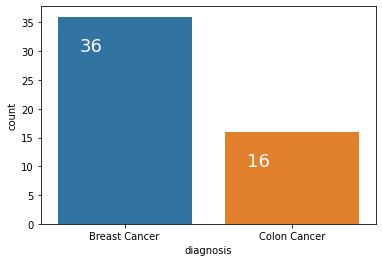

In [15]:
# plot counts of diagnosis for breast cancer vs colon cancer
ax = sns.countplot(x ='diagnosis', data = df_diagnosis_pt)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', 
                color='white', size=18)

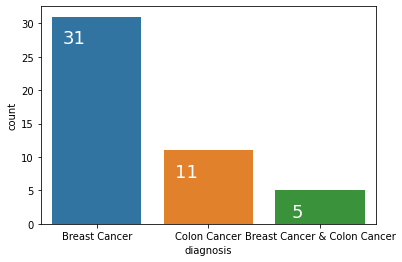

In [16]:
df_diagnosis_pt.loc[(df_diagnosis_pt['count'] == 2), 'diagnosis']='Breast Cancer & Colon Cancer'
df_diagnosis_pt = df_diagnosis_pt.drop_duplicates(subset=['patient_id'])

ax = sns.countplot(x ='diagnosis', data = df_diagnosis_pt)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()+1.2), ha='center', va='top', 
                color='white', size=18)

### Q2: Date difference between initial diagnose date and initial treatment date

array([[<AxesSubplot:title={'center':'date_diff'}>]], dtype=object)

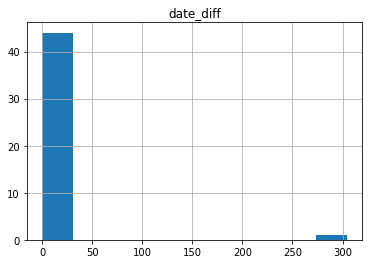

In [17]:
# get first treatment after the first diagnosis
df_treatment_first = df_treatment[['patient_id', 'treatment_date', 'diagnosis_date']].sort_values(['patient_id', 'treatment_date']).drop_duplicates(subset=['patient_id'])
df_treatment_first['date_diff'] = (df_treatment_first['treatment_date']-df_treatment_first['diagnosis_date']).dt.days

# remove treatment starts before diagnosis
df_treatment_first = df_treatment_first.loc[df_treatment_first['date_diff'] >= 0] 

# plot out date differences on histogram
df_treatment_first.hist(column='date_diff') 

array([[<AxesSubplot:title={'center':'date_diff'}>]], dtype=object)

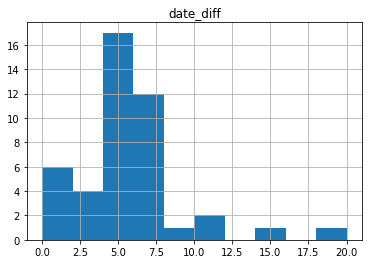

In [18]:
# removing outlier (date difference >= 30 days)
df_treatment_first = df_treatment_first.loc[df_treatment_first['date_diff'] < 30] 
df_treatment_first.hist(column='date_diff')

### Q3: Which regimen is mostly used?

In [22]:
# create an id for unique patient_id + treatment_date combination for initial diagnosis
df_treatment_first['id'] = df_treatment_first['patient_id'].astype(str)+"_"+df_treatment_first['treatment_date'].astype(str)

# map first diagnose date to the treatment table
mydict = {}
for row in df_diagnosis_pt.itertuples():
    k = row.patient_id
    v = row.diagnosis
    mydict[k]=v
df_treatment['diagnosis'] = df_treatment['patient_id'].map(mydict)

# identify initial diagnosis in the treatment table
mydict = {}
for row in df_treatment_first.itertuples():
    k = row.id
    v = 'Y'
    mydict[k]=v
df_treatment['initial'] = df_treatment['id'].map(mydict)
df_treatment

,patient_id,treatment_date,drug_code,diagnosis_date,id,count,date_diff,time_min,time_max,duration,diagnosis,initial
3,2038,2010-01-24,A,2010-01-21,2038_2010-01-24,2.0,3,3,2587,2584,Breast Cancer,Y
5,2038,2010-01-24,B,2010-01-21,2038_2010-01-24,2.0,3,3,2587,2584,Breast Cancer,Y
8,2038,2010-01-27,A,2010-01-21,2038_2010-01-27,2.0,6,3,2587,2584,Breast Cancer,NaN
9,2038,2010-01-27,B,2010-01-21,2038_2010-01-27,2.0,6,3,2587,2584,Breast Cancer,NaN
15,2038,2010-01-30,A,2010-01-21,2038_2010-01-30,2.0,9,3,2587,2584,Breast Cancer,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1024,9489,2013-09-18,C,2013-08-19,9489_2013-09-18,NaN,30,6,53,47,Breast Cancer,NaN
1031,9489,2013-09-24,C,2013-08-19,9489_2013-09-24,NaN,36,6,53,47,Breast Cancer,NaN
1035,9489,2013-09-30,C,2013-08-19,9489_2013-09-30,NaN,42,6,53,47,Breast Cancer,NaN
1039,9489,2013-10-06,C,2013-08-19,9489_2013-10-06,NaN,48,6,53,47,Breast Cancer,NaN


In [25]:
df_treatment.to_csv("/Users/yzm9199/Downloads/df_treatment.csv")

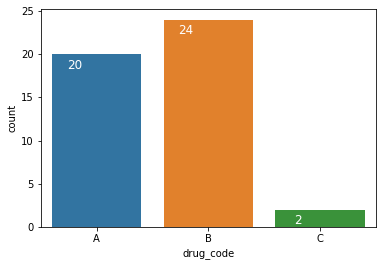

In [28]:
# get a subset of patients with initial diagnosis of breast cancer and only first line treatment
df_treatment_breast = df_treatment.loc[df_treatment['initial'] == 'Y'].loc[df_treatment['diagnosis'] == 'Breast Cancer'].sort_values(['drug_code'])

ax = sns.countplot(x ='drug_code', data = df_treatment_breast)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()+1.2), ha='center', va='top', 
                color='white', size=12)

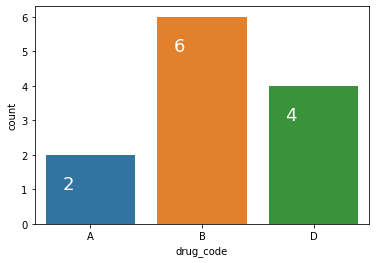

In [26]:
# get a subset of patients with initial diagnosis of colon cancer and only first line treatment
df_treatment_colon = df_treatment.loc[df_treatment['initial'] == 'Y'].loc[df_treatment['diagnosis'] == 'Colon Cancer'].sort_values(['drug_code'])

ax = sns.countplot(x ='drug_code', data = df_treatment_colon)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', 
                color='white', size=18)

### Q4: Treatment duration for treatment A vs B as first-line for breast cancer

In [29]:
# remove treatments with durations > 500 or <=0  on first line treatments
df_ab = df_treatment_breast[df_treatment_breast['duration']<500][df_treatment_breast['duration']>0]

# remove records with treatments C
df_ab = df_ab[df_ab['drug_code']!='C']

# remove records with concurrent treatments
df_ab = df_ab[df_ab['count']!=2]
df_ab

<ipython-input-29-c1baf52305f0>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ab = df_treatment_breast[df_treatment_breast['duration']<500][df_treatment_breast['duration']>0]


,patient_id,treatment_date,drug_code,diagnosis_date,id,count,date_diff,time_min,time_max,duration,diagnosis,initial
792,7937,2013-01-12,A,2013-01-06,7937_2013-01-12,NaN,6,6,80,74,Breast Cancer,Y
882,7976,2013-03-11,A,2013-03-06,7976_2013-03-11,NaN,5,5,82,77,Breast Cancer,Y
937,8480,2013-05-22,A,2013-05-16,8480_2013-05-22,NaN,6,6,83,77,Breast Cancer,Y
2,2120,2010-01-23,B,2010-01-09,2120_2010-01-23,NaN,14,14,52,38,Breast Cancer,Y
94,2607,2010-07-03,B,2010-06-13,2607_2010-07-03,NaN,20,20,94,74,Breast Cancer,Y
0,2720,2010-01-20,B,2010-01-09,2720_2010-01-20,NaN,11,11,87,76,Breast Cancer,Y
136,2762,2011-01-10,B,2011-01-07,2762_2011-01-10,NaN,3,3,79,76,Breast Cancer,Y
118,3025,2010-12-21,B,2010-12-15,3025_2010-12-21,NaN,6,6,83,77,Breast Cancer,Y


In [30]:
df_treatment[df_treatment['patient_id']==2120]

,patient_id,treatment_date,drug_code,diagnosis_date,id,count,date_diff,time_min,time_max,duration,diagnosis,initial
2,2120,2010-01-23,B,2010-01-09,2120_2010-01-23,NaN,14,14,52,38,Breast Cancer,Y
4,2120,2010-01-24,A,2010-01-09,2120_2010-01-24,NaN,15,14,52,38,Breast Cancer,NaN
6,2120,2010-01-26,A,2010-01-09,2120_2010-01-26,2.0,17,14,52,38,Breast Cancer,NaN
7,2120,2010-01-26,B,2010-01-09,2120_2010-01-26,2.0,17,14,52,38,Breast Cancer,NaN
10,2120,2010-01-27,A,2010-01-09,2120_2010-01-27,2.0,18,14,52,38,Breast Cancer,NaN
11,2120,2010-01-27,B,2010-01-09,2120_2010-01-27,2.0,18,14,52,38,Breast Cancer,NaN
13,2120,2010-01-29,A,2010-01-09,2120_2010-01-29,2.0,20,14,52,38,Breast Cancer,NaN
14,2120,2010-01-29,B,2010-01-09,2120_2010-01-29,2.0,20,14,52,38,Breast Cancer,NaN
18,2120,2010-02-01,A,2010-01-09,2120_2010-02-01,2.0,23,14,52,38,Breast Cancer,NaN
19,2120,2010-02-01,B,2010-01-09,2120_2010-02-01,2.0,23,14,52,38,Breast Cancer,NaN


In [31]:
# remove records with 'patient_id' ==2120
df_ab = df_ab[df_ab['patient_id']!=2120]
df_ab

,patient_id,treatment_date,drug_code,diagnosis_date,id,count,date_diff,time_min,time_max,duration,diagnosis,initial
792,7937,2013-01-12,A,2013-01-06,7937_2013-01-12,NaN,6,6,80,74,Breast Cancer,Y
882,7976,2013-03-11,A,2013-03-06,7976_2013-03-11,NaN,5,5,82,77,Breast Cancer,Y
937,8480,2013-05-22,A,2013-05-16,8480_2013-05-22,NaN,6,6,83,77,Breast Cancer,Y
94,2607,2010-07-03,B,2010-06-13,2607_2010-07-03,NaN,20,20,94,74,Breast Cancer,Y
0,2720,2010-01-20,B,2010-01-09,2720_2010-01-20,NaN,11,11,87,76,Breast Cancer,Y
136,2762,2011-01-10,B,2011-01-07,2762_2011-01-10,NaN,3,3,79,76,Breast Cancer,Y
118,3025,2010-12-21,B,2010-12-15,3025_2010-12-21,NaN,6,6,83,77,Breast Cancer,Y


In [32]:
# patients with first-line treatment using A only
df_a = df_ab[df_ab['drug_code']=='A']

# patients with first-line treatment using B only
df_b = df_ab[df_ab['drug_code']=='B']

# t-test
from scipy import stats
stats.ttest_ind(df_a['duration'], df_b['duration'])

Ttest_indResult(statistic=0.22323504886820392, pvalue=0.8321861976917552)